# Artificial Intelligence Engineer Nanodegree - Probabilistic Models
## Project: Sign Language Recognition System
- [Introduction](#intro)
- [Part 1 Feature Selection](#part1_tutorial)
    - [Tutorial](#part1_tutorial)
    - [Features Submission](#part1_submission)
    - [Features Unittest](#part1_test)
- [Part 2 Train the models](#part2_tutorial)
    - [Tutorial](#part2_tutorial)
    - [Model Selection Score Submission](#part2_submission)
    - [Model Score Unittest](#part2_test)
- [Part 3 Build a Recognizer](#part3_tutorial)
    - [Tutorial](#part3_tutorial)
    - [Recognizer Submission](#part3_submission)
    - [Recognizer Unittest](#part3_test)
- [Part 4 (OPTIONAL) Improve the WER with Language Models](#part4_info)

<a id='intro'></a>
## Introduction
The overall goal of this project is to build a word recognizer for American Sign Language video sequences, demonstrating the power of probabalistic models.  In particular, this project employs  [hidden Markov models (HMM's)](https://en.wikipedia.org/wiki/Hidden_Markov_model) to analyze a series of measurements taken from videos of American Sign Language (ASL) collected for research (see the [RWTH-BOSTON-104 Database](http://www-i6.informatik.rwth-aachen.de/~dreuw/database-rwth-boston-104.php)).  In this video, the right-hand x and y locations are plotted as the speaker signs the sentence.
[![ASLR demo](http://www-i6.informatik.rwth-aachen.de/~dreuw/images/demosample.png)](https://drive.google.com/open?id=0B_5qGuFe-wbhUXRuVnNZVnMtam8)

The raw data, train, and test sets are pre-defined.  You will derive a variety of feature sets (explored in Part 1), as well as implement three different model selection criterion to determine the optimal number of hidden states for each word model (explored in Part 2). Finally, in Part 3 you will implement the recognizer and compare the effects the different combinations of feature sets and model selection criteria.  

At the end of each Part, complete the submission cells with implementations, answer all questions, and pass the unit tests.  Then submit the completed notebook for review!

<a id='part1_tutorial'></a>
## PART 1: Data

### Features Tutorial
##### Load the initial database
A data handler designed for this database is provided in the student codebase as the `AslDb` class in the `asl_data` module.  This handler creates the initial [pandas](http://pandas.pydata.org/pandas-docs/stable/) dataframe from the corpus of data included in the `data` directory as well as dictionaries suitable for extracting data in a format friendly to the [hmmlearn](https://hmmlearn.readthedocs.io/en/latest/) library.  We'll use those to create models in Part 2.

To start, let's set up the initial database and select an example set of features for the training set.  At the end of Part 1, you will create additional feature sets for experimentation. 

In [61]:
import numpy as np
import pandas as pd
from asl_data import AslDb


asl = AslDb() # initializes the database
asl.df.head() # displays the first five rows of the asl database, indexed by video and frame

left-x  left-y  right-x  right-y  nose-x  nose-y  speaker
video frame                                                           
98    0         149     181      170      175     161      62  woman-1
      1         149     181      170      175     161      62  woman-1
      2         149     181      170      175     161      62  woman-1
      3         149     181      170      175     161      62  woman-1
      4         149     181      170      175     161      62  woman-1

In [62]:
asl.df.ix[98,1]  # look at the data available for an individual frame

left-x         149
left-y         181
right-x        170
right-y        175
nose-x         161
nose-y          62
speaker    woman-1
Name: (98, 1), dtype: object

The frame represented by video 98, frame 1 is shown here:
![Video 98](http://www-i6.informatik.rwth-aachen.de/~dreuw/database/rwth-boston-104/overview/images/orig/098-start.jpg)

##### Feature selection for training the model
The objective of feature selection when training a model is to choose the most relevant variables while keeping the model as simple as possible, thus reducing training time.  We can use the raw features already provided or derive our own and add columns to the pandas dataframe `asl.df` for selection. As an example, in the next cell a feature named `'grnd-ry'` is added. This feature is the difference between the right-hand y value and the nose y value, which serves as the "ground" right y value. 

In [63]:
asl.df['grnd-ry'] = asl.df['right-y'] - asl.df['nose-y']
asl.df.head()  # the new feature 'grnd-ry' is now in the frames dictionary

left-x  left-y  right-x  right-y  nose-x  nose-y  speaker  \
video frame                                                              
98    0         149     181      170      175     161      62  woman-1   
      1         149     181      170      175     161      62  woman-1   
      2         149     181      170      175     161      62  woman-1   
      3         149     181      170      175     161      62  woman-1   
      4         149     181      170      175     161      62  woman-1   

             grnd-ry  
video frame           
98    0          113  
      1          113  
      2          113  
      3          113  
      4          113

##### Try it!

In [64]:
from asl_utils import test_features_tryit
# TODO add df columns for 'grnd-rx', 'grnd-ly', 'grnd-lx' representing differences between hand and nose locations
for hand in ['left', 'right']:
    for axis in ['x', 'y']:
        asl.df['grnd-'+hand[0]+axis] = asl.df[hand+'-'+axis] - asl.df['nose-'+axis]
# test the code
test_features_tryit(asl)

asl.df sample


left-x  left-y  right-x  right-y  nose-x  nose-y  speaker  \
video frame                                                              
98    0         149     181      170      175     161      62  woman-1   
      1         149     181      170      175     161      62  woman-1   
      2         149     181      170      175     161      62  woman-1   
      3         149     181      170      175     161      62  woman-1   
      4         149     181      170      175     161      62  woman-1   

             grnd-ry  grnd-lx  grnd-ly  grnd-rx  
video frame                                      
98    0          113      -12      119        9  
      1          113      -12      119        9  
      2          113      -12      119        9  
      3          113      -12      119        9  
      4          113      -12      119        9

In [65]:
# collect the features into a list
features_ground = ['grnd-rx','grnd-ry','grnd-lx','grnd-ly']
 #show a single set of features for a given (video, frame) tuple
[asl.df.ix[98,1][v] for v in features_ground]

[9, 113, -12, 119]

##### Build the training set
Now that we have a feature list defined, we can pass that list to the `build_training` method to collect the features for all the words in the training set.  Each word in the training set has multiple examples from various videos.  Below we can see the unique words that have been loaded into the training set:

In [66]:
training = asl.build_training(features_ground)
print("Training words: {}".format(training.words))

Training words: ['JOHN', 'WRITE', 'HOMEWORK', 'IX-1P', 'SEE', 'YESTERDAY', 'IX', 'LOVE', 'MARY', 'CAN', 'GO', 'GO1', 'FUTURE', 'GO2', 'PARTY', 'FUTURE1', 'HIT', 'BLAME', 'FRED', 'FISH', 'WONT', 'EAT', 'BUT', 'CHICKEN', 'VEGETABLE', 'CHINA', 'PEOPLE', 'PREFER', 'BROCCOLI', 'LIKE', 'LEAVE', 'SAY', 'BUY', 'HOUSE', 'KNOW', 'CORN', 'CORN1', 'THINK', 'NOT', 'PAST', 'LIVE', 'CHICAGO', 'CAR', 'SHOULD', 'DECIDE', 'VISIT', 'MOVIE', 'WANT', 'SELL', 'TOMORROW', 'NEXT-WEEK', 'NEW-YORK', 'LAST-WEEK', 'WILL', 'FINISH', 'ANN', 'READ', 'BOOK', 'CHOCOLATE', 'FIND', 'SOMETHING-ONE', 'POSS', 'BROTHER', 'ARRIVE', 'HERE', 'GIVE', 'MAN', 'NEW', 'COAT', 'WOMAN', 'GIVE1', 'HAVE', 'FRANK', 'BREAK-DOWN', 'SEARCH-FOR', 'WHO', 'WHAT', 'LEG', 'FRIEND', 'CANDY', 'BLUE', 'SUE', 'BUY1', 'STOLEN', 'OLD', 'STUDENT', 'VIDEOTAPE', 'BORROW', 'MOTHER', 'POTATO', 'TELL', 'BILL', 'THROW', 'APPLE', 'NAME', 'SHOOT', 'SAY-1P', 'SELF', 'GROUP', 'JANA', 'TOY1', 'MANY', 'TOY', 'ALL', 'BOY', 'TEACHER', 'GIRL', 'BOX', 'GIVE2', 'GIVE3

The training data in `training` is an object of class `WordsData` defined in the `asl_data` module.  in addition to the `words` list, data can be accessed with the `get_all_sequences`, `get_all_Xlengths`, `get_word_sequences`, and `get_word_Xlengths` methods. We need the `get_word_Xlengths` method to train multiple sequences with the `hmmlearn` library.  In the following example, notice that there are two lists; the first is a concatenation of all the sequences(the X portion) and the second is a list of the sequence lengths(the Lengths portion).

In [67]:
training.get_word_Xlengths('CHOCOLATE')

(array([[-11,  48,   7, 120],
        [-11,  48,   8, 109],
        [ -8,  49,  11,  98],
        [ -7,  50,   7,  87],
        [ -4,  54,   7,  77],
        [ -4,  54,   6,  69],
        [ -4,  54,   6,  69],
        [-13,  52,   6,  69],
        [-13,  52,   6,  69],
        [ -8,  51,   6,  69],
        [ -8,  51,   6,  69],
        [ -8,  51,   6,  69],
        [ -8,  51,   6,  69],
        [ -8,  51,   6,  69],
        [-10,  59,   7,  71],
        [-15,  64,   9,  77],
        [-17,  75,  13,  81],
        [ -4,  48,  -4, 113],
        [ -2,  53,  -4, 113],
        [ -4,  55,   2,  98],
        [ -4,  58,   2,  98],
        [ -1,  59,   2,  89],
        [ -1,  59,  -1,  84],
        [ -1,  59,  -1,  84],
        [ -7,  63,  -1,  84],
        [ -7,  63,  -1,  84],
        [ -7,  63,   3,  83],
        [ -7,  63,   3,  83],
        [ -7,  63,   3,  83],
        [ -7,  63,   3,  83],
        [ -7,  63,   3,  83],
        [ -7,  63,   3,  83],
        [ -7,  63,   3,  83],
        [ 

###### More feature sets
So far we have a simple feature set that is enough to get started modeling.  However, we might get better results if we manipulate the raw values a bit more, so we will go ahead and set up some other options now for experimentation later.  For example, we could normalize each speaker's range of motion with grouped statistics using [Pandas stats](http://pandas.pydata.org/pandas-docs/stable/api.html#api-dataframe-stats) functions and [pandas groupby](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.groupby.html).  Below is an example for finding the means of all speaker subgroups.

In [68]:
df_means = asl.df.groupby('speaker').mean()
df_means

,left-x,left-y,right-x,right-y,nose-x,nose-y,grnd-ry,grnd-lx,grnd-ly,grnd-rx
speaker,,,,,,,,,,
man-1,206.248203,218.679449,155.464350,150.371031,175.031756,61.642600,88.728430,31.216447,157.036848,-19.567406
woman-1,164.661438,161.271242,151.017865,117.332462,162.655120,57.245098,60.087364,2.006318,104.026144,-11.637255
woman-2,183.214509,176.527232,156.866295,119.835714,170.318973,58.022098,61.813616,12.895536,118.505134,-13.452679


To select a mean that matches by speaker, use the pandas [map](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.Series.map.html) method:

In [69]:
asl.df['left-x-mean']= asl.df['speaker'].map(df_means['left-x'])
asl.df.head()

left-x  left-y  right-x  right-y  nose-x  nose-y  speaker  \
video frame                                                              
98    0         149     181      170      175     161      62  woman-1   
      1         149     181      170      175     161      62  woman-1   
      2         149     181      170      175     161      62  woman-1   
      3         149     181      170      175     161      62  woman-1   
      4         149     181      170      175     161      62  woman-1   

             grnd-ry  grnd-lx  grnd-ly  grnd-rx  left-x-mean  
video frame                                                   
98    0          113      -12      119        9   164.661438  
      1          113      -12      119        9   164.661438  
      2          113      -12      119        9   164.661438  
      3          113      -12      119        9   164.661438  
      4          113      -12      119        9   164.661438

##### Try it!

In [70]:
from asl_utils import test_std_tryit
# TODO Create a dataframe named `df_std` with standard deviations grouped by speaker
df_std = asl.df.groupby('speaker').std()

# test the code
test_std_tryit(df_std)

df_std


,left-x,left-y,right-x,right-y,nose-x,nose-y,grnd-ry,grnd-lx,grnd-ly,grnd-rx,left-x-mean
speaker,,,,,,,,,,,
man-1,15.154425,36.328485,18.901917,54.902340,6.654573,5.520045,53.487999,15.080360,36.572749,20.269032,0.0
woman-1,17.573442,26.594521,16.459943,34.667787,3.549392,3.538330,33.972660,17.328941,27.117393,16.764706,0.0
woman-2,15.388711,28.825025,14.890288,39.649111,4.099760,3.416167,39.128572,15.050938,29.320655,16.191324,0.0


<a id='part1_submission'></a>
### Features Implementation Submission
Implement four feature sets and answer the question that follows.
- normalized Cartesian coordinates
    - use *mean* and *standard deviation* statistics and the [standard score](https://en.wikipedia.org/wiki/Standard_score) equation to account for speakers with different heights and arm length
    
- polar coordinates
    - calculate polar coordinates with [Cartesian to polar equations](https://en.wikipedia.org/wiki/Polar_coordinate_system#Converting_between_polar_and_Cartesian_coordinates)
    - use the [np.arctan2](https://docs.scipy.org/doc/numpy-1.10.0/reference/generated/numpy.arctan2.html) function and *swap the x and y axes* to move the $0$ to $2\pi$ discontinuity to 12 o'clock instead of 3 o'clock;  in other words, the normal break in radians value from $0$ to $2\pi$ occurs directly to the left of the speaker's nose, which may be in the signing area and interfere with results.  By swapping the x and y axes, that discontinuity move to directly above the speaker's head, an area not generally used in signing.

- delta difference
    - as described in Thad's lecture, use the difference in values between one frame and the next frames as features
    - pandas [diff method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.diff.html) and [fillna method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.fillna.html) will be helpful for this one

- custom features
    - These are your own design; combine techniques used above or come up with something else entirely. We look forward to seeing what you come up with! 
    Some ideas to get you started:
        - normalize using a [feature scaling equation](https://en.wikipedia.org/wiki/Feature_scaling)
        - normalize the polar coordinates
        - adding additional deltas


In [71]:
# TODO add features for normalized by speaker values of left, right, x, y
# Name these 'norm-rx', 'norm-ry', 'norm-lx', and 'norm-ly'
# using Z-score scaling (X-Xmean)/Xstd
for hand in ['left', 'right']:
    for axis in ['x', 'y']:
        asl.df['norm-'+hand[0]+axis] = ((asl.df[hand+'-'+axis] -
                                         asl.df['speaker'].map(df_means[hand+'-'+axis]))
                                        /
                                        asl.df['speaker'].map(df_std[hand+'-'+axis]))
                                        
features_norm = ['norm-rx', 'norm-ry', 'norm-lx','norm-ly']

In [72]:
# TODO add features for polar coordinate values where the nose is the origin
# Name these 'polar-rr', 'polar-rtheta', 'polar-lr', and 'polar-ltheta'
# Note that 'polar-rr' and 'polar-rtheta' refer to the radius and angle

for hand in ['left', 'right']:
    xs = asl.df['grnd-'+hand[0]+'x']
    ys = asl.df['grnd-'+hand[0]+'y']
    asl.df['polar-'+hand[0]+'r'] = np.sqrt(xs*xs + ys*ys)
    asl.df['polar-'+hand[0]+'theta'] = np.arctan2(xs,ys)

features_polar = ['polar-rr', 'polar-rtheta', 'polar-lr', 'polar-ltheta']

In [73]:
# TODO add features for left, right, x, y differences by one time step, i.e. the "delta" values discussed in the lecture
# Name these 'delta-rx', 'delta-ry', 'delta-lx', and 'delta-ly'

for hand in ['left', 'right']:
    for axis in ['x', 'y']:
        asl.df['delta-'+hand[0]+axis] = asl.df[hand+'-'+axis].diff().fillna(0)

features_delta = ['delta-rx', 'delta-ry', 'delta-lx', 'delta-ly']

In [74]:
# TODO add features of your own design, which may be a combination of the above or something else
# Name these whatever you would like
df_mins = asl.df.groupby('speaker').min()
df_maxs = asl.df.groupby('speaker').max()
df_box = pd.DataFrame()
df_box['xmin'] = df_mins['right-x']
df_box['xmax'] = df_maxs['left-x']
df_box['ymin'] = df_mins[['left-y','right-y']].min(axis=1)
df_box['ymax'] = df_maxs[['left-y','right-y']].max(axis=1)
df_box['Dx'] = df_box['xmax'] - df_box['xmin']
df_box['Dy'] = df_box['ymax'] - df_box['ymin']

for hand in ['left', 'right']:
    for axis in ['x', 'y']:
        asl.df['box-'+hand[0]+axis] = ((asl.df[hand+'-'+axis] - asl.df['speaker'].map(df_box[axis+'min'])) /
                                       asl.df['speaker'].map(df_box['D'+axis]))

#for hand in ['left', 'right']:
#    for axis in ['x', 'y']:
#        asl.df['boxdelta-'+hand[0]+axis] = asl.df['box-'+hand[0]+axis].diff().fillna(0)
        
# TODO define a list named 'features_custom' for building the training set
features_custom = ['box-rx', 'box-ry', 'box-lx', 'box-ly']
#features_custom += ['boxdelta-rx', 'boxdelta-ry', 'boxdelta-lx', 'boxdelta-ly']

**Question 1:**  What custom features did you choose for the features_custom set and why?

**Answer 1:**
My `custom` features are a different normalisation of `x` and `y` coordinates. This is done by first locating a "bounding box" that contains the range of the speaker's hand-movements; these features then effectively measure hand positions relative to this box, where `(0,0)` corresponds to the top-left edge of the box for the corresponding speaker and `(1,1)` corresponds to the bottom-right edge of the box. Note that, the way I have defined the bounding box in the code above, the rescaled `x` coordinate can still theoretically fall outside the range $[0,1]$, although this is unlikely.

Like the `ground` and `polar` feature sets, my custom features preserve information on the position of the hands; however, features are rescaled to take into account different length scales for different speakers. One key difference of this approach compared to the `norm` feature set is that the relative difference in position between the two hands is explicitly preserved (the `norm` feature set rescales each hand's position with respect to a different anchor). The `delta` feature set, in contrast to my `custom` features, does not preserve position information at all.

<a id='part1_test'></a>
### Features Unit Testing
Run the following unit tests as a sanity check on the defined "ground", "norm", "polar", and 'delta"
feature sets.  The test simply looks for some valid values but is not exhaustive.  However, the project should not be submitted if these tests don't pass.

In [95]:
import unittest
# import numpy as np

class TestFeatures(unittest.TestCase):

    def test_features_ground(self):
        sample = (asl.df.ix[98, 1][features_ground]).tolist()
        self.assertEqual(sample, [9, 113, -12, 119])

    def test_features_norm(self):
        sample = (asl.df.ix[98, 1][features_norm]).tolist()
        np.testing.assert_almost_equal(sample, [ 1.153,  1.663, -0.891,  0.742], 3)

    def test_features_polar(self):
        sample = (asl.df.ix[98,1][features_polar]).tolist()
        np.testing.assert_almost_equal(sample, [113.3578, 0.0794, 119.603, -0.1005], 3)

    def test_features_delta(self):
        sample = (asl.df.ix[98, 0][features_delta]).tolist()
        self.assertEqual(sample, [0, 0, 0, 0])
        sample = (asl.df.ix[98, 18][features_delta]).tolist()
        self.assertTrue(sample in [[-16, -5, -2, 4], [-14, -9, 0, 0]], "Sample value found was {}".format(sample))
                         
suite = unittest.TestLoader().loadTestsFromModule(TestFeatures())
unittest.TextTestRunner().run(suite)

....
----------------------------------------------------------------------
Ran 4 tests in 0.012s

OK


<unittest.runner.TextTestResult run=4 errors=0 failures=0>

<a id='part2_tutorial'></a>
## PART 2: Model Selection
### Model Selection Tutorial
The objective of Model Selection is to tune the number of states for each word HMM prior to testing on unseen data.  In this section you will explore three methods: 
- Log likelihood using cross-validation folds (CV)
- Bayesian Information Criterion (BIC)
- Discriminative Information Criterion (DIC) 

##### Train a single word
Now that we have built a training set with sequence data, we can "train" models for each word.  As a simple starting example, we train a single word using Gaussian hidden Markov models (HMM).   By using the `fit` method during training, the [Baum-Welch Expectation-Maximization](https://en.wikipedia.org/wiki/Baum%E2%80%93Welch_algorithm) (EM) algorithm is invoked iteratively to find the best estimate for the model *for the number of hidden states specified* from a group of sample seequences. For this example, we *assume* the correct number of hidden states is 3, but that is just a guess.  How do we know what the "best" number of states for training is?  We will need to find some model selection technique to choose the best parameter.

In [71]:
import warnings
from hmmlearn.hmm import GaussianHMM

def train_a_word(word, num_hidden_states, features):
    
    warnings.filterwarnings("ignore", category=DeprecationWarning)
    training = asl.build_training(features)  
    X, lengths = training.get_word_Xlengths(word)
    model = GaussianHMM(n_components=num_hidden_states, n_iter=1000).fit(X, lengths)
    logL = model.score(X, lengths)
    return model, logL

demoword = 'BOOK'
model, logL = train_a_word(demoword, 3, features_ground)
print("Number of states trained in model for {} is {}".format(demoword, model.n_components))
print("logL = {}".format(logL))

Number of states trained in model for BOOK is 3
logL = -2331.11381274332


The HMM model has been trained and information can be pulled from the model, including means and variances for each feature and hidden state.  The [log likelihood](http://math.stackexchange.com/questions/892832/why-we-consider-log-likelihood-instead-of-likelihood-in-gaussian-distribution) for any individual sample or group of samples can also be calculated with the `score` method.

In [72]:
def show_model_stats(word, model):
    print("Number of states trained in model for {} is {}".format(word, model.n_components))    
    variance=np.array([np.diag(model.covars_[i]) for i in range(model.n_components)])    
    for i in range(model.n_components):  # for each hidden state
        print("hidden state #{}".format(i))
        print("mean = ", model.means_[i])
        print("variance = ", variance[i])
        print()
    old_prec = np.get_printoptions()['precision']
    old_supp = np.get_printoptions()['suppress']
    old_fm   = np.get_printoptions()['floatmode']
    np.set_printoptions(precision=2, suppress=True, floatmode='fixed')
    print("trans_mat = \n{}".format(model.transmat_))
    print()
    print("start_prob = {}".format(model.startprob_))
    np.set_printoptions(precision=old_prec, suppress=old_supp, floatmode=old_fm)
    
show_model_stats(demoword, model)

Number of states trained in model for BOOK is 3
hidden state #0
mean =  [-1.12415027 69.44164191 17.02866283 77.7231196 ]
variance =  [19.70434594 16.83041492 30.51552305 11.03678246]

hidden state #1
mean =  [-11.45300909  94.109178    19.03512475 102.2030162 ]
variance =  [ 77.403668   203.35441965  26.68898447 156.12444034]

hidden state #2
mean =  [-3.46504869 50.66686933 14.02391587 52.04731066]
variance =  [49.12346305 43.04799144 39.35109609 47.24195772]

trans_mat = 
[[0.96 0.04 0.00]
 [0.00 1.00 0.00]
 [0.02 0.00 0.98]]

start_prob = [0.11 0.28 0.61]


##### Try it!
Experiment by changing the feature set, word, and/or num_hidden_states values in the next cell to see changes in values.  

In [73]:
my_testword = 'BOOK'
model, logL = train_a_word(my_testword, 5, features_delta) # Experiment here with different parameters
show_model_stats(my_testword, model)
print("logL = {}".format(logL))

Number of states trained in model for BOOK is 5
hidden state #0
mean =  [0. 0. 0. 0.]
variance =  [0.00018519 0.00018519 0.00018519 0.00018519]

hidden state #1
mean =  [ 0.02659675  6.28626081 -0.28172668  5.8351874 ]
variance =  [ 4.61712292 17.05002759 10.09409165 19.75801677]

hidden state #2
mean =  [ 5.30799678  6.02267092 -2.96743889 -5.10925566]
variance =  [11.86062537 19.64221018  8.34486994 16.23255174]

hidden state #3
mean =  [ 2.32766123  1.05049113 -5.5285377   0.42508405]
variance =  [5.47186218 2.38277477 3.76057895 3.24229961]

hidden state #4
mean =  [-2.56573155  0.9984431   2.28926365  1.12851608]
variance =  [5.87180928 4.92101311 9.58685395 8.36681322]

trans_mat = 
[[0.47 0.23 0.00 0.04 0.26]
 [0.21 0.79 0.00 0.00 0.00]
 [0.12 0.00 0.50 0.20 0.18]
 [0.47 0.00 0.00 0.43 0.11]
 [0.33 0.04 0.00 0.00 0.63]]

start_prob = [0.06 0.16 0.51 0.27 0.00]
logL = -591.6820173032429


##### Visualize the hidden states
We can plot the means and variances for each state and feature.  Try varying the number of states trained for the HMM model and examine the variances.  Are there some models that are "better" than others?  How can you tell?  We would like to hear what you think in the classroom online.

In [25]:
%matplotlib inline

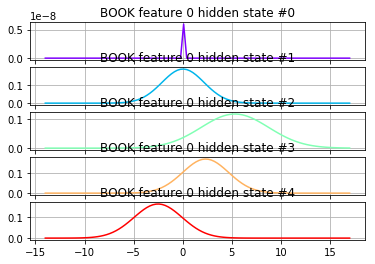

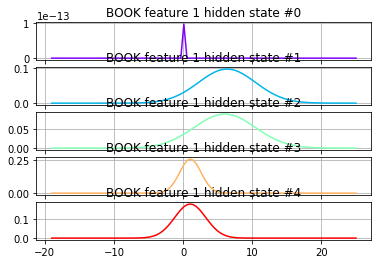

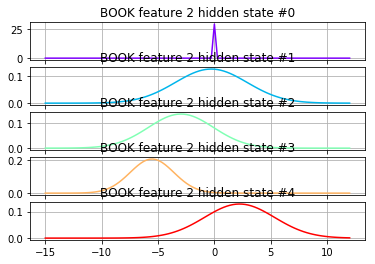

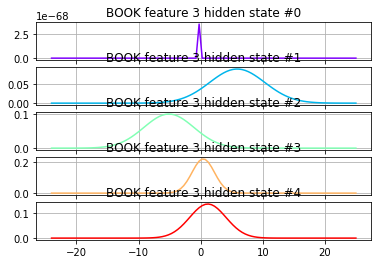

In [35]:
import math
from matplotlib import (cm, pyplot as plt, mlab)

def visualize(word, model):
    """ visualize the input model for a particular word """
    variance=np.array([np.diag(model.covars_[i]) for i in range(model.n_components)])
    figures = []
    for parm_idx in range(len(model.means_[0])):
        xmin = int(min(model.means_[:,parm_idx]) - max(variance[:,parm_idx]))
        xmax = int(max(model.means_[:,parm_idx]) + max(variance[:,parm_idx]))
        fig, axs = plt.subplots(model.n_components, sharex=True, sharey=False)
        colours = cm.rainbow(np.linspace(0, 1, model.n_components))
        for i, (ax, colour) in enumerate(zip(axs, colours)):
            x = np.linspace(xmin, xmax, 100)
            mu = model.means_[i,parm_idx]
            sigma = math.sqrt(np.diag(model.covars_[i])[parm_idx])
            ax.plot(x, mlab.normpdf(x, mu, sigma), c=colour)
            ax.set_title("{} feature {} hidden state #{}".format(word, parm_idx, i))

            ax.grid(True)
        figures.append(plt)
    for p in figures:
        p.show()
        
visualize(my_testword, model)

#####  ModelSelector class
Review the `ModelSelector` class from the codebase found in the `my_model_selectors.py` module.  It is designed to be a strategy pattern for choosing different model selectors.  For the project submission in this section, subclass `SelectorModel` to implement the following model selectors.  In other words, you will write your own classes/functions in the `my_model_selectors.py` module and run them from this notebook:

- `SelectorCV `:  Log likelihood with CV
- `SelectorBIC`: BIC 
- `SelectorDIC`: DIC

You will train each word in the training set with a range of values for the number of hidden states, and then score these alternatives with the model selector, choosing the "best" according to each strategy. The simple case of training with a constant value for `n_components` can be called using the provided `SelectorConstant` subclass as follow:

In [36]:
from my_model_selectors import SelectorConstant

training = asl.build_training(features_ground)  # Experiment here with different feature sets defined in part 1
word = 'VEGETABLE' # Experiment here with different words
model = SelectorConstant(training.get_all_sequences(), training.get_all_Xlengths(), word, n_constant=3).select()
print("Number of states trained in model for {} is {}".format(word, model.n_components))

Number of states trained in model for VEGETABLE is 3


##### Cross-validation folds
If we simply score the model with the Log Likelihood calculated from the feature sequences it has been trained on, we should expect that more complex models will have higher likelihoods. However, that doesn't tell us which would have a better likelihood score on unseen data.  The model will likely be overfit as complexity is added.  To estimate which topology model is better using only the training data, we can compare scores using cross-validation.  One technique for cross-validation is to break the training set into "folds" and rotate which fold is left out of training.  The "left out" fold scored.  This gives us a proxy method of finding the best model to use on "unseen data". In the following example, a set of word sequences is broken into three folds using the [scikit-learn Kfold](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html) class object. When you implement `SelectorCV`, you will use this technique.

In [77]:
from sklearn.model_selection import KFold

training = asl.build_training(features_ground) # Experiment here with different feature sets
word = 'VEGETABLE' # Experiment here with different words
word_sequences = training.get_word_sequences(word)
split_method = KFold()
for cv_train_idx, cv_test_idx in split_method.split(word_sequences):
    print("Train fold indices:{} Test fold indices:{}".format(cv_train_idx, cv_test_idx))  # view indices of the folds

Train fold indices:[2 3 4 5] Test fold indices:[0 1]
Train fold indices:[0 1 4 5] Test fold indices:[2 3]
Train fold indices:[0 1 2 3] Test fold indices:[4 5]


**Tip:** In order to run `hmmlearn` training using the X,lengths tuples on the new folds, subsets must be combined based on the indices given for the folds.  A helper utility has been provided in the `asl_utils` module named `combine_sequences` for this purpose.

##### Scoring models with other criterion
Scoring model topologies with **BIC** balances fit and complexity within the training set for each word.  In the BIC equation, a penalty term penalizes complexity to avoid overfitting, so that it is not necessary to also use cross-validation in the selection process.  There are a number of references on the internet for this criterion.  These [slides](http://www2.imm.dtu.dk/courses/02433/doc/ch6_slides.pdf) include a formula you may find helpful for your implementation.

The advantages of scoring model topologies with **DIC** over BIC are presented by Alain Biem in this [reference](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.58.6208&rep=rep1&type=pdf) (also found [here](https://pdfs.semanticscholar.org/ed3d/7c4a5f607201f3848d4c02dd9ba17c791fc2.pdf)).  DIC scores the discriminant ability of a training set for one word against competing words.  Instead of a penalty term for complexity, it provides a penalty if model liklihoods for non-matching words are too similar to model likelihoods for the correct word in the word set.

<a id='part2_submission'></a>
### Model Selection Implementation Submission
Implement `SelectorCV`, `SelectorBIC`, and `SelectorDIC` classes in the `my_model_selectors.py` module.  Run the selectors on the following five words. Then answer the questions about your results.

**Tip:** The `hmmlearn` library may not be able to train or score all models.  Implement try/except contructs as necessary to eliminate non-viable models from consideration.

In [8]:
words_to_train = ['FISH', 'BOOK', 'VEGETABLE', 'FUTURE', 'JOHN']
import timeit

In [9]:
# autoreload for automatically reloading changes made in my_model_selectors and my_recognizer
%load_ext autoreload
%autoreload 2

In [54]:
# TODO: Implement SelectorCV in my_model_selector.py
from my_model_selectors import SelectorCV

training = asl.build_training(features_ground)  # Experiment here with different feature sets defined in part 1
sequences = training.get_all_sequences()
Xlengths = training.get_all_Xlengths()
for word in words_to_train:
    start = timeit.default_timer()
    model = SelectorCV(sequences, Xlengths, word, 
                    min_n_components=2, max_n_components=15, random_state = 14, verbose=False).select()
    end = timeit.default_timer()-start
    if model is not None:
        print("Training complete for {} with {} states with time {} seconds".format(word, model.n_components, end))
    else:
        print("Training failed for {}".format(word))

Training complete for FISH with 11 states with time 0.609984576003626 seconds
Training complete for BOOK with 6 states with time 4.403935414011357 seconds
Training complete for VEGETABLE with 2 states with time 1.9779009699996095 seconds
Training complete for FUTURE with 2 states with time 4.026997187000234 seconds
Training complete for JOHN with 12 states with time 38.87745785998413 seconds


In [101]:
# TODO: Implement SelectorBIC in module my_model_selectors.py
from my_model_selectors import SelectorBIC

training = asl.build_training(features_delta)  # Experiment here with different feature sets defined in part 1
sequences = training.get_all_sequences()
Xlengths = training.get_all_Xlengths()
for word in words_to_train:
    start = timeit.default_timer()
    model = SelectorBIC(sequences, Xlengths, word, 
                    min_n_components=2, max_n_components=15, random_state = 14, verbose=False).select()
    end = timeit.default_timer()-start
    if model is not None:
        print("Training complete for {} with {} states with time {} seconds".format(word, model.n_components, end))
    else:
        print("Training failed for {}".format(word))

Training complete for FISH with 4 states with time 0.4638882179860957 seconds
Training complete for BOOK with 8 states with time 3.061778973962646 seconds
Training complete for VEGETABLE with 3 states with time 0.960066715022549 seconds
Training complete for FUTURE with 5 states with time 2.0399623589473777 seconds
Training complete for JOHN with 6 states with time 22.75909007899463 seconds


In [50]:
# TODO: Implement SelectorDIC in module my_model_selectors.py
from my_model_selectors import SelectorDIC

training = asl.build_training(features_ground)  # Experiment here with different feature sets defined in part 1
sequences = training.get_all_sequences()
Xlengths = training.get_all_Xlengths()
for word in words_to_train:
    start = timeit.default_timer()
    model = SelectorDIC(sequences, Xlengths, word, 
                    min_n_components=2, max_n_components=15, random_state = 14, verbose=False).select()
    end = timeit.default_timer()-start
    if model is not None:
        print("Training complete for {} with {} states with time {} seconds".format(word, model.n_components, end))
    else:
        print("Training failed for {}".format(word))

Training complete for FISH with 3 states with time 0.8575913179956842 seconds
Training complete for BOOK with 15 states with time 4.031154308991972 seconds
Training complete for VEGETABLE with 15 states with time 2.657957761985017 seconds
Training complete for FUTURE with 15 states with time 4.049392571003409 seconds
Training complete for JOHN with 15 states with time 21.235030069976347 seconds


**Question 2:**  Compare and contrast the possible advantages and disadvantages of the various model selectors implemented.

**Answer 2:**

CV:
- Reduces chance of overfitting by validating model performance (for the purpose of topology selection) on a different set of samples to those used for training HMM parameters.
- This means it can use a commonly understood metric for model fit (log-likelihood) while reducing the risk of overfitting.
- Likely to work well when there are many sample sequences for each trained word, but where there are few (like in this dataset) there is likely to be high variance in the results.
- Cross-validation cannot be done at all if there is only a single sequence for a given word (as opposed to BIC and DIC).

BIC:
- All data can be used for training as there is no need for a hold-out sample set.
- Relatively simple to interpret: BIC takes log-likelihood and compensates for the latter's tendancy to naturally increase with sample size and number of model parameters to produce a modified score.
- Therefore also simple to implement as BIC is a straightforward modification of the maximum likelihood criterion.
- Since no validation set is required, BIC can be used even for words with only a single training sequence, unlike CV.
- However, the derivation of BIC is only approximate and in general it may over- or under-compensate for varying the number of parameters; without out-of-sample testing (and possibly the use of a regularisation parameter) one cannot be sure if the resultant model is under or overfitting.

DIC:
- Picks the model that best discriminates between the target class and (the average performance on) all other classes. In this sense it is arguably better suited to classification than BIC (which only tries to maximise the fit between different models for the target class).
- Unlike BIC, DIC will sometimes sacrifice low model complexity in order to get better classification performance, which is an advantage when the latter is the ultimate objective.
- However, this increased complexity may lead to trained models being harder to interpret compared to those selected by BIC (e.g. in training above, DIC often selects models with the maximum 15 components).
- DIC will also be slower than BIC due to the need to calculate model scores on alternate classes.

<a id='part2_test'></a>
### Model Selector Unit Testing
Run the following unit tests as a sanity check on the implemented model selectors.  The test simply looks for valid interfaces  but is not exhaustive. However, the project should not be submitted if these tests don't pass.

In [30]:
from asl_test_model_selectors import TestSelectors
suite = unittest.TestLoader().loadTestsFromModule(TestSelectors())
unittest.TextTestRunner().run(suite)

....
----------------------------------------------------------------------
Ran 4 tests in 58.021s

OK


<unittest.runner.TextTestResult run=4 errors=0 failures=0>

<a id='part3_tutorial'></a>
## PART 3: Recognizer
The objective of this section is to "put it all together".  Using the four feature sets created and the three model selectors, you will experiment with the models and present your results.  Instead of training only five specific words as in the previous section, train the entire set with a feature set and model selector strategy.  
### Recognizer Tutorial
##### Train the full training set
The following example trains the entire set with the example `features_ground` and `SelectorConstant` features and model selector.  Use this pattern for you experimentation and final submission cells.



In [31]:
from my_model_selectors import SelectorConstant

def train_all_words(features, model_selector):
    training = asl.build_training(features)  # Experiment here with different feature sets defined in part 1
    sequences = training.get_all_sequences()
    Xlengths = training.get_all_Xlengths()
    model_dict = {}
    for word in training.words:
        model = model_selector(sequences, Xlengths, word, 
                        n_constant=3).select()
        model_dict[word]=model
    return model_dict

models = train_all_words(features_ground, SelectorConstant)
print("Number of word models returned = {}".format(len(models)))

Number of word models returned = 112


##### Load the test set
The `build_test` method in `ASLdb` is similar to the `build_training` method already presented, but there are a few differences:
- the object is type `SinglesData` 
- the internal dictionary keys are the index of the test word rather than the word itself
- the getter methods are `get_all_sequences`, `get_all_Xlengths`, `get_item_sequences` and `get_item_Xlengths`

In [32]:
test_set = asl.build_test(features_ground)
print("Number of test set items: {}".format(test_set.num_items))
print("Number of test set sentences: {}".format(len(test_set.sentences_index)))

Number of test set items: 178
Number of test set sentences: 40


<a id='part3_submission'></a>
### Recognizer Implementation Submission
For the final project submission, students must implement a recognizer following guidance in the `my_recognizer.py` module.  Experiment with the four feature sets and the three model selection methods (that's 12 possible combinations). You can add and remove cells for experimentation or run the recognizers locally in some other way during your experiments, but retain the results for your discussion.  For submission, you will provide code cells of **only three** interesting combinations for your discussion (see questions below). At least one of these should produce a word error rate of less than 60%, i.e. WER < 0.60 . 

**Tip:** The hmmlearn library may not be able to train or score all models.  Implement try/except contructs as necessary to eliminate non-viable models from consideration.

In [41]:
# TODO implement the recognize method in my_recognizer
from my_recognizer import recognize
from asl_utils import show_errors

In [105]:
# TODO Choose a feature set and model selector
features = features_ground # change as needed
model_selector = SelectorCV # change as needed

# TODO Recognize the test set and display the result with the show_errors method
models = train_all_words(features, model_selector)
test_set = asl.build_test(features)
probabilities, guesses = recognize(models, test_set)
show_errors(guesses, test_set)


**** WER = 0.5280898876404494
Total correct: 84 out of 178
Video  Recognized                                                    Correct
    2: JOHN *COAT *ARRIVE                                            JOHN WRITE HOMEWORK
    7: JOHN *GO1 *HAVE *WHAT                                         JOHN CAN GO CAN
   12: *IX CAN *CAN CAN                                              JOHN CAN GO CAN
   21: JOHN *VIDEOTAPE *JOHN *TELL *CAR *CAR EAT *BROTHER            JOHN FISH WONT EAT BUT CAN EAT CHICKEN
   25: JOHN *TELL IX *TELL IX                                        JOHN LIKE IX IX IX
   28: JOHN *TELL IX IX IX                                           JOHN LIKE IX IX IX
   30: JOHN LIKE IX *MARY IX                                         JOHN LIKE IX IX IX
   36: *WHO VEGETABLE *IX *GIVE *BILL *MARY                          MARY VEGETABLE KNOW IX LIKE CORN1
   40: *JANA *BILL *FUTURE1 *JANA *IX                                JOHN IX THINK MARY LOVE
   43: JOHN *SHOULD BUY HOUSE       

In [106]:
# TODO Choose a feature set and model selector
features = features_custom # change as needed
model_selector = SelectorCV # change as needed

# TODO Recognize the test set and display the result with the show_errors method
models = train_all_words(features, model_selector)
test_set = asl.build_test(features)
probabilities, guesses = recognize(models, test_set)
show_errors(guesses, test_set)


**** WER = 0.5337078651685393
Total correct: 83 out of 178
Video  Recognized                                                    Correct
    2: *IX-1P WRITE HOMEWORK                                         JOHN WRITE HOMEWORK
    7: JOHN *NEXT-WEEK GO CAN                                        JOHN CAN GO CAN
   12: JOHN *WHAT *GO1 CAN                                           JOHN CAN GO CAN
   21: *ANN FISH *HOMEWORK *CORN1 *GIVE3 *PARTY *CHICKEN *MOTHER     JOHN FISH WONT EAT BUT CAN EAT CHICKEN
   25: *ANN LIKE *ANN *LIKE *ANN                                     JOHN LIKE IX IX IX
   28: *ANN LIKE *ANN *ANN *ANN                                      JOHN LIKE IX IX IX
   30: JOHN LIKE *LOVE *LIKE *MARY                                   JOHN LIKE IX IX IX
   36: MARY *JANA *THINK *MARY *FRANK *JOHN                          MARY VEGETABLE KNOW IX LIKE CORN1
   40: JOHN *MARY *CORN *VEGETABLE LOVE                              JOHN IX THINK MARY LOVE
   43: JOHN *JOHN BUY HOUSE         

In [107]:
# TODO Choose a feature set and model selector
features = features_polar # change as needed
model_selector = SelectorBIC # change as needed

# TODO Recognize the test set and display the result with the show_errors method
models = train_all_words(features, model_selector)
test_set = asl.build_test(features)
probabilities, guesses = recognize(models, test_set)
show_errors(guesses, test_set)


**** WER = 0.5393258426966292
Total correct: 82 out of 178
Video  Recognized                                                    Correct
    2: *GO WRITE *NEW                                                JOHN WRITE HOMEWORK
    7: JOHN *PEOPLE GO *ARRIVE                                       JOHN CAN GO CAN
   12: JOHN *WHAT *GO1 CAN                                           JOHN CAN GO CAN
   21: JOHN *NEW WONT *NOT *GIVE1 *TEACHER *FUTURE *WHO              JOHN FISH WONT EAT BUT CAN EAT CHICKEN
   25: JOHN LIKE *LOVE *WHO IX                                       JOHN LIKE IX IX IX
   28: JOHN *WHO *FUTURE *WHO IX                                     JOHN LIKE IX IX IX
   30: JOHN LIKE *MARY *MARY *MARY                                   JOHN LIKE IX IX IX
   36: *VISIT VEGETABLE *GIRL *GIVE *MARY *MARY                      MARY VEGETABLE KNOW IX LIKE CORN1
   40: JOHN *VISIT *FUTURE1 *JOHN *MARY                              JOHN IX THINK MARY LOVE
   43: JOHN *FUTURE BUY HOUSE       

**Question 3:**  Summarize the error results from three combinations of features and model selectors.  What was the "best" combination and why?  What additional information might we use to improve our WER?  For more insight on improving WER, take a look at the introduction to Part 4.

**Answer 3:**

*NB See [Appendix](#appendix) for full results and some charts.*

Here are results for the best three models:

| Features |	Selector | Test_Time |	Train_Time |	WER |
|---|---|---|---|---|
| features_ground |	SelectorCV |	5.247242 |	111.486328 |	0.528090 |
| features_custom |	SelectorCV |	5.639029 |	126.098695 |	0.533708 |
| features_polar |	SelectorBIC |	5.653613 |	70.157889 |	0.539326 |

Given the overall range of WER scores, and the variability possible during training, these three models roughly perform as well as each other.

A key difference between these three features sets (`ground`, `custom` and `polar`) and the two that did not perform as well (`norm` and `delta`) is that the former preserve location information with respect to a common anchor in the picture – i.e. the nose for `ground` and `polar`, the bounding box of the full range of movements *by both arms* for `custom`. In contrast, `delta` erases all positional information (it effectively only measures the velocities of the hands), whereas `norm` does preserve some positional information, but uses separate anchors for each hand (i.e. the respective mean positions of the hands); this means that with `norm` it would still be difficult to know as accurately where one hand is in relation to the other.

Considering the best three features (`ground`, `custom` and `polar`), I note that of these only `custom` does any length rescaling. However, this does not seem to have much impact on performance (indeed `ground` performs marginally better than `custom`). This may be because the videos used in this project are already quite well normalised (i.e. the speaker's body takes up roughly the same area of the video image for each speaker), meaning there is little to be gained from further renormalising for differing length scales between speakers.

Turning to the different model selection methods, it is clear from the full set of results (see chart [here](#appendix-selector-chart)) that `SelectorConstant` performs the worst. This is not a surprise, since this method selects a fixed model topology for all words. Generally `SelectorCV` tends to do better than `SelectorBIC` or `SelectorDIC`, but not in all cases. This may be because one needs several samples (per word being modelled) to do effective cross validation (i.e. with low variance) whereas, for this dataset, there are often few samples per word – indeed only a single sample for some words.

(Note that, to make `SelectorCV` work for the recogniser at all, I implemented it such that it would fall back to in-sample maximum likelihood for (less common) words where there is only one training sequence available – i.e. it would not perform cross validation at all. Otherwise it would not have been possible to use `SelectorCV` on this dataset.)

Again, looking at this [chart](#appendix-selector-chart), it is not clear that DIC is consistently better than BIC (or vice versa). Under such circumstances, BIC seems preferable as it is faster for training the models (since model scores do not need to be calculated for all alternate classes).


<a id='part3_test'></a>
### Recognizer Unit Tests
Run the following unit tests as a sanity check on the defined recognizer.  The test simply looks for some valid values but is not exhaustive. However, the project should not be submitted if these tests don't pass.

In [135]:
from asl_test_recognizer import TestRecognize
suite = unittest.TestLoader().loadTestsFromModule(TestRecognize())
unittest.TextTestRunner().run(suite)

..
----------------------------------------------------------------------
Ran 2 tests in 35.102s

OK


<unittest.runner.TextTestResult run=2 errors=0 failures=0>

<a id='part4_info'></a>
## PART 4: (OPTIONAL)  Improve the WER with Language Models
We've squeezed just about as much as we can out of the model and still only get about 50% of the words right! Surely we can do better than that.  Probability to the rescue again in the form of [statistical language models (SLM)](https://en.wikipedia.org/wiki/Language_model).  The basic idea is that each word has some probability of occurrence within the set, and some probability that it is adjacent to specific other words. We can use that additional information to make better choices.

##### Additional reading and resources
- [Introduction to N-grams (Stanford Jurafsky slides)](https://web.stanford.edu/class/cs124/lec/languagemodeling.pdf)
- [Speech Recognition Techniques for a Sign Language Recognition System, Philippe Dreuw et al](https://www-i6.informatik.rwth-aachen.de/publications/download/154/Dreuw--2007.pdf) see the improved results of applying LM on *this* data!
- [SLM data for *this* ASL dataset](ftp://wasserstoff.informatik.rwth-aachen.de/pub/rwth-boston-104/lm/)

##### Optional challenge
The recognizer you implemented in Part 3 is equivalent to a "0-gram" SLM.  Improve the WER with the SLM data provided with the data set in the link above using "1-gram", "2-gram", and/or "3-gram" statistics. The `probabilities` data you've already calculated will be useful and can be turned into a pandas DataFrame if desired (see next cell).  
Good luck!  Share your results with the class!

In [ ]:
# create a DataFrame of log likelihoods for the test word items
df_probs = pd.DataFrame(data=probabilities)
df_probs.head()

<a id='appendix'></a>
## APPENDIX: Full results for Part 3

First I calculate WERs for all combinations of features and model selection methods:

In [104]:
def calculate_WER(guesses, test_set):
    """ Calculate WER as per the algorithm used in asl_utils.show_errors
    """
    S = 0
    N = len(test_set.wordlist)
    num_test_words = len(test_set.wordlist)
    if len(guesses) != num_test_words:
        print("Size of guesses must equal number of test words ({})!".format(num_test_words))
    for word_id in range(num_test_words):
        if guesses[word_id] != test_set.wordlist[word_id]:
            S += 1
    return float(S) / float(N)

features_list = ['features_ground', 'features_norm', 'features_polar', 'features_delta', 'features_custom']
selectors_list = ['SelectorConstant', 'SelectorCV', 'SelectorBIC', 'SelectorDIC']

results = []

for features_str in features_list:
    for selector_str in selectors_list:
        try:
            features = eval(features_str)
            model_selector = eval(selector_str)
    
            train_start = timeit.default_timer()
            models = train_all_words(features, model_selector)
            train_time = timeit.default_timer() - train_start
            test_set = asl.build_test(features)
            test_start = timeit.default_timer()
            probabilities, guesses = recognize(models, test_set)
            test_time = timeit.default_timer() - test_start
            results.append({'Features': features_str,
                            'Selector': selector_str,
                            'WER': calculate_WER(guesses, test_set),
                            'Train_Time': train_time,
                            'Test_Time': test_time})
        except:
            print("Error on {}, {}".format(features_str, selector_str))
            continue
pd.DataFrame(results)

,Features,Selector,Test_Time,Train_Time,WER
0,features_ground,SelectorConstant,5.374388,14.884949,0.674157
1,features_ground,SelectorCV,5.247242,111.486328,0.528090
2,features_ground,SelectorBIC,5.720481,63.008788,0.550562
3,features_ground,SelectorDIC,5.947836,152.452512,0.578652
4,features_norm,SelectorConstant,5.307759,16.000986,0.623596
5,features_norm,SelectorCV,5.670497,124.962439,0.601124
6,features_norm,SelectorBIC,5.555424,66.758883,0.612360
7,features_norm,SelectorDIC,6.144865,172.641232,0.623596
8,features_polar,SelectorConstant,5.350992,15.099261,0.623596
9,features_polar,SelectorCV,5.341052,118.534517,0.573034


Here are the best three models:

In [120]:
results_df = pd.DataFrame(results).set_index(['Features', 'Selector'])
results_df.sort_values('WER')[:3]

,,Test_Time,Train_Time,WER
Features,Selector,,,
features_ground,SelectorCV,5.247242,111.486328,0.528090
features_custom,SelectorCV,5.639029,126.098695,0.533708
features_polar,SelectorBIC,5.653613,70.157889,0.539326


Let's look at how the different model selection methods do by feature:
<a id='appendix-selector-chart'></a>

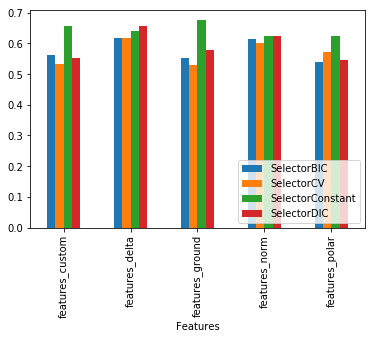

In [133]:
results_df['WER'].unstack().plot.bar()
plt.gca().legend(loc=4)
plt.show()

Note that `SelectorConstant` tends to do worst (unsurprisingly) across all features, but beyond that it is hard to discern a consistent pattern. `SelectorCV` tends to do better than BIC or DIC, but even this is not reliable or particularly significant. BIC and DIC have similar levels of performance, which makes BIC prefereable since it is significantly quicker during model training.